In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Synthetic Datasets

In [3]:
def display_boxplots(csv_filename, metric="AUUC", whis=[5, 95]):
    res_df = pd.read_csv(csv_filename)
    df = res_df.pivot(index='split', columns='method', values=metric)
    df = df[["ITE_best", "ITE_2M", "MITE_2M", "ITE_SDR", "MITE_SDR", "Oracle"]].subtract(df["RAND"], axis='index')
    plt.figure(figsize=(8,4))
    #plt.figure(figsize=(16,8))
    plt.boxplot(df.values, whis=whis, showmeans=True)
    plt.xticks(range(1, len(df.columns) + 1), df.columns)
    plt.ylabel('Δ' + metric)
    plt.show()
        
def display_pehe(directory, name):
    fontsize = 15
    m_dfs = [(method, pd.DataFrame(columns=["q5", "q50", "q95"])) for method in ['ITE_2M', 'MITE_2M']]
    for filename in os.listdir(directory):
        m = re.match('^result_' + re.escape(name) + r'-([\d\.]+).csv$', filename)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(directory, filename))
        for method, m_df in m_dfs:
            m_df.loc[float(m.group(1))] = df[df['method'] == method]['RMSE'].quantile([0.05, 0.5, 0.95]).values
    assert len(m_dfs[0][1]) > 0, "No 'single' result file in directory"
    
    plt.figure(figsize=(16, 12))
    plt.xscale('symlog')
    for (method, m_df), color in zip(m_dfs, ['blue', 'red']):
        label = "$%s_{%s}$" % tuple(method.split('_'))
        m_df.sort_index(inplace=True)
        gamma = m_df.index * 100
        plt.plot(gamma, m_df['q5'], label=label + ' 5%', color=color, linestyle=':')
        plt.plot(gamma, m_df['q50'], label=label + ' median', color=color)
        plt.plot(gamma, m_df['q95'], label=label + ' 95%', color=color, linestyle=':')
        
    gamma = m_dfs[0][1].index
    plt.vlines(3.7, 0, 0.003, colors='g', linestyles='solid', label='$\gamma$ CRITEO-UPLIFT1')
    plt.xticks(gamma * 100, map(str, gamma), rotation='vertical', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("$\gamma$", fontsize=fontsize)
    plt.ylabel("$\sqrt{PEHE}$", fontsize=fontsize)
    plt.legend(framealpha=1, fontsize=fontsize)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

## Dataset with multiple compliance values

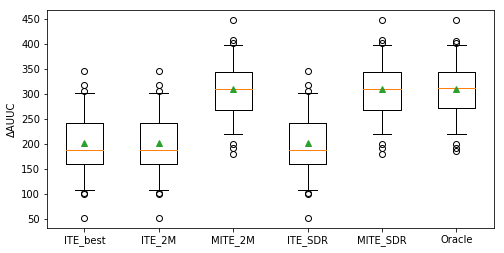

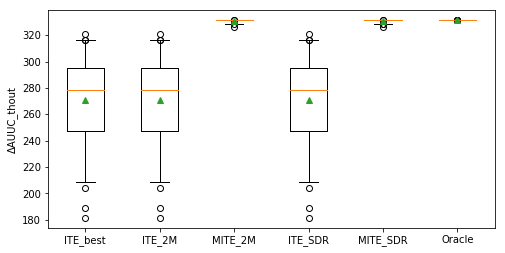

In [4]:
path = "./synth_results/"
display_boxplots(os.path.join(path, "result_multi.csv"))
display_boxplots(os.path.join(path, "result_multi.csv"), "AUUC_thout")

## Multiple datasets with constant compliance values

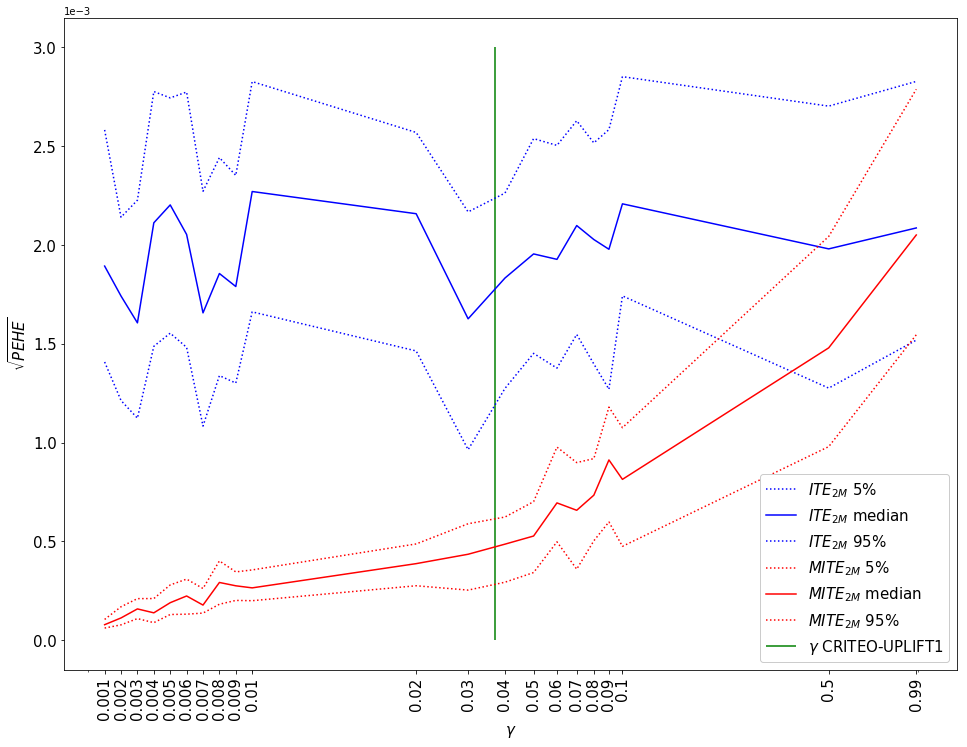

In [5]:
path = "./synth_results/"
display_pehe(path, "single")

# CRITEO-UPLIFT1 Dataset

In [6]:
def display_boxplots_opendataset(csv_filename, whis=[5, 95], penalty=None, c=None):
    res_df = pd.read_csv(csv_filename)
    res_df['ΔAUUC'] = res_df['AUUC'] - res_df['AUUC_random']
    if penalty is not None:
        res_df = res_df[res_df['penalty'] == penalty]
    if c is not None:
        res_df = res_df[res_df['C'] == c]

    # get the best hyper-params combination (best ΔAUUC mean computed on splits)
    hyper_params = ['method', 'C', 'penalty']
    delta_auuc_means = res_df.groupby(hyper_params)['ΔAUUC'].mean().to_frame().reset_index()
    #display(delta_auuc_means)
    max_auuc_idx = delta_auuc_means.groupby('method')['ΔAUUC'].idxmax().values
    delta_auuc_maxs = delta_auuc_means.loc[max_auuc_idx]
    display(delta_auuc_maxs.rename(columns={'ΔAUUC': 'mean ΔAUUC'}))
    i_res = res_df.set_index(hyper_params).index
    i_delta_auuc_maxs = delta_auuc_maxs.set_index(hyper_params).index
    res_df = res_df[i_res.isin(i_delta_auuc_maxs)]
    df = res_df.pivot(index='split', columns='method', values='ΔAUUC')[["ITE_2M", "MITE_2M", "ITE_SDR", "MITE_SDR"]]
    plt.figure(figsize=(8,4))
    values = df.values
    #values = [col[~np.isnan(col)] for col in df.values.T]  # in case of partial grid exploration
    plt.boxplot(values, whis=whis, showmeans=True)
    plt.xticks(range(1, len(df.columns) + 1), df.columns)
    plt.ylabel('ΔAUUC')
    plt.show()   

,method,C,penalty,mean ΔAUUC
0,ITE_2M,10,l2,20249.085940
1,ITE_SDR,10,l2,20179.615970
2,MITE_2M,10,l2,21507.813960
3,MITE_SDR,10,l2,21333.441887


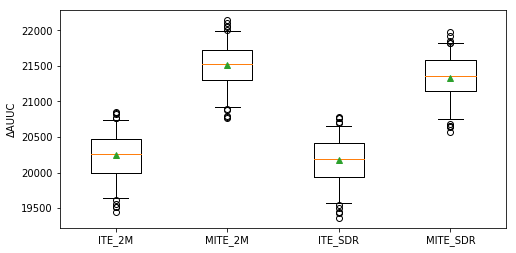

In [7]:
path = "./criteo_results"
display_boxplots_opendataset(os.path.join(path, 'result_criteo.csv'))

,method,C,penalty,mean ΔAUUC
14,ITE_2M,100000.0,l1,20484.044762
20,ITE_SDR,1.0,l1,20596.476241
39,MITE_2M,10.0,l2,21507.813960
53,MITE_SDR,1.0,l2,21454.981632


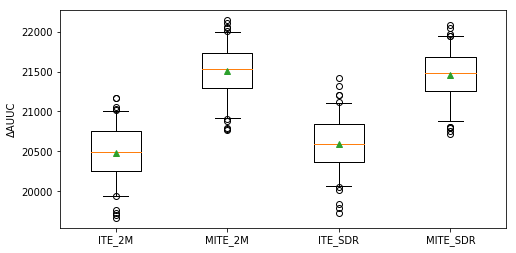

,method,C,penalty,mean ΔAUUC
0,ITE_2M,10.0,l2,20249.085940
1,ITE_SDR,10.0,l2,20179.615970
2,MITE_2M,10.0,l2,21507.813960
3,MITE_SDR,10.0,l2,21333.441887


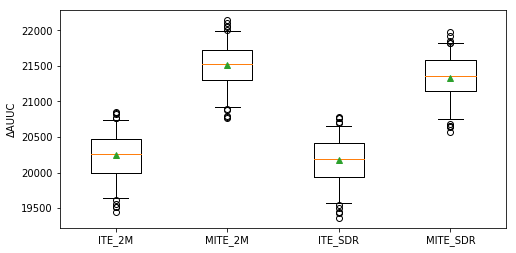

In [8]:
# Full exploration of the hyper-parameters grid
path = "./criteo_results"
# best hyper-parameters per model
display_boxplots_opendataset(os.path.join(path, 'result_criteo_fullgrid.csv'))
# select one set of hyper-parameters
display_boxplots_opendataset(os.path.join(path, 'result_criteo_fullgrid.csv'), penalty='l2', c=10)